In [1]:
import sys
sys.path.append('../')
import env

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from collections import namedtuple

In [3]:
one_length = env.AREA_ONE_LENGTH()

In [4]:
def area_to_contour(area_id):
    area_id = int(area_id)
    left = str(area_id // one_length)
    right = str(area_id % one_length) + '0'
    return left+right


def contour_to_area(contour_id):
    contour_id = str(contour_id)
    left = int(contour_id[0]) * one_length
    right = int(contour_id[1])
    
    return left+right

In [5]:
csv_array = {}
def main(args, array):
    df = pd.read_csv(env.get_full_path('2D', args),
                                                        encoding='Shift_JISx0213')
    df['time'] = df['time'].apply(lambda x: str(int(x)))
    df['area'] = df['area'].apply(lambda x: area_to_contour(x))
    df['people'] = df['people'].apply(lambda x: int(x))

    group_list = df.groupby(['time'], sort=False)
    for _times, _group in group_list:
        array[args.dir][args.ratio][args.seed][args.csv][_times] = _group
        
env.for_default_init(main, csv_array, ['mobile', 'census1', 'census2'])

In [6]:
people = 'p10000'
ratio = 'r4'
seed = 's123'

In [7]:
csv_array['p10000']['r4']['s123']['census1']['3600'].head()

,time,area,people
0,3600,000,0
1,3600,010,13
2,3600,020,0
3,3600,030,0
4,3600,040,0


In [8]:
contour_list = [area_to_contour(i) for i in range(one_length**2)]

In [9]:
class Coordinate:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __add__(a,b):
        return Coordinate(a.x+b.x, a.y+b.y)
    
    def distance(self):
        return round(np.sqrt(self.x**2 + self.y**2), 3)

In [10]:
def get_around_contour(contour_id):    
    array = {}
    
    y = int(contour_id[0])
    x = int(contour_id[1])
    
    array[1,0] = east = str(y) + str(x+1) + '0'
    array[1,1] = north_east = str(y+1) + str(x+1) + '0'
    array[0,1] = north = str(y+1) + str(x) + '0'
    array[-1,1] = north_west = str(y+1) + str(x-1) + '0'
    array[-1,0] = west = str(y) + str(x-1) + '0'
    array[-1,-1] = south_west = str(y-1) + str(x-1) + '0'
    array[0,-1] = south = str(y-1) + str(x) + '0'
    array[1,-1] = south_east = str(y-1) + str(x+1) + '0'
    
    for _index, _item in array.items():
        if (len(_item) > 3) or (_item.find(str(one_length)) != -1):
            array[_index] = -1
    
    return array

In [11]:
coordinate_array = {}
for _area in env.AREA_LIST_CONTOUR():
    coordinate_array[_area] = None
coordinate_array[-1] = -1

def set_coordinate_3d(contour_id, center=Coordinate(0,0)):    
    coordinate_array[contour_id] = center 

    for _xy, _area in get_around_contour(contour_id).items():
        if coordinate_array[_area] == None:
            coordinate = Coordinate(_xy[0], _xy[1])
            coordinate_array[_area] = center + coordinate
            set_coordinate_3d(_area, center+coordinate)

In [12]:
set_coordinate_3d('540')
coordinate_array.pop(-1)

-1

In [14]:
def create_network(args, array):
    for _times in env.TIMES_LIST():
        df = csv_array[args.dir][args.ratio][args.seed][args.csv][_times].copy()

        network = nx.DiGraph()
        for _area in contour_list:
            network.add_node(_area)

            coordinate = get_around_contour(_area)
            for _around_area in coordinate.values():
                if _around_area != -1:
                    network.add_edge(_area, _around_area, 
                                     people=df.loc[df['area'] == _around_area, 'people'].values[0], 
                                     distance=coordinate_array[_around_area].distance()
                    )
                
        array[args.dir][args.ratio][args.seed][args.csv][_times] = network
    return array

network_array = {}
env.for_default_init(create_network, network_array, ['census1', 'census2'])

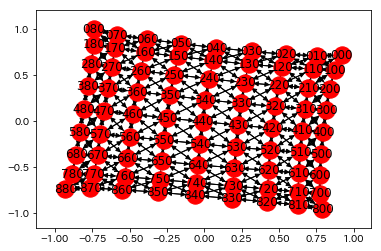

AtlasView({'550': {'people': 17, 'distance': 1.0}, '650': {'people': 19, 'distance': 1.414}, '640': {'people': 14, 'distance': 1.0}, '630': {'people': 6, 'distance': 1.414}, '530': {'people': 19, 'distance': 1.0}, '430': {'people': 0, 'distance': 1.414}, '440': {'people': 20, 'distance': 1.0}, '450': {'people': 16, 'distance': 1.414}})

In [23]:
n = network_array[people][ratio][seed]['census1']['3600'].copy()
nx.draw_networkx(n)
plt.show()
n['540']

In [17]:
import random

start_array = {}

for _times in env.TIMES_LIST():
    start_array[_times] = {}
    df = csv_array[people][ratio][seed]['mobile'][_times].copy()
    df['people'] = df['people'] // 4
    df = df[df['people'] != 0]

    stack_area = list(df['area'].values)
    stack_poeple = df['people'].sum()
    print(_times, ', stack: ', stack_poeple)

    for vehicle_id in range(stack_poeple):    
        random_area = random.choice(stack_area)
        df_choiced = df.loc[df['area'] == random_area, :]
        start_array[_times][vehicle_id] = df_choiced['area'].values[0]
        df.loc[df_choiced.index[0], 'people'] -= 1

        if df.loc[df_choiced.index[0], 'people'] == 0:
            stack_area.remove(random_area)
            df = df.drop(df_choiced.index[0])

3600 , stack:  52
7200 , stack:  144
10800 , stack:  149
14400 , stack:  144
18000 , stack:  107
21600 , stack:  52


In [51]:
import math

# 7200から開始した時、3600mobileの人数+(7200mobileの人数-3600mobileの人数)をcensus1とcensus2の割合ごとに人数を分ける
# 0~3600, 3600~7200の後者を指定する
def calcurlate_stack(end_time):
#     end_time = '3600'
    times_list = env.TIMES_LIST()
    time_index = times_list.index(end_time)

    mobile_end = csv_array[people][ratio][seed]['mobile'][end_time]['people'].copy() // 4
    mobile_start = pd.Series()
    if time_index != 0:
        mobile_start = csv_array[people][ratio][seed]['mobile'][times_list[time_index-1]]['people'].copy() // 4

    census1 = csv_array[people][ratio][seed]['census1'][times_list[time_index]]['people'].copy()
    census2 = csv_array[people][ratio][seed]['census2'][times_list[time_index]]['people'].copy()

    census_sum = census1.sum() + census2.sum()
    mobile_diff = mobile_end.sum() - mobile_start.sum()

    # previousの人数計算
    # 継続人数を計算
    continue1 = math.modf(census1.sum() / census_sum * mobile_start.sum())
    continue2 = math.modf(census2.sum() / census_sum * mobile_start.sum())
    decimal = round(continue1[0]+continue2[0])
    continue1 = int(continue1[1])
    continue2 = int(continue2[1])
    if continue1 > continue2:
        continue1 += decimal
    else:
        continue2 += decimal

    # 差分==新しく出現 の人数を計算
    new1 = math.modf(census1.sum() / census_sum * mobile_diff)
    new2 = math.modf(census2.sum() / census_sum * mobile_diff)
    decimal = round(new1[0]+new2[0])
    new1 = int(new1[1])
    new2 = int(new2[1])
    if new1 > new2:
        new1 += decimal
    else:
        new2 += decimal

    print(mobile_start.sum(), ' : ',mobile_diff)
    print('census1: ', continue1, ', ', new1)
    print('census2: ', continue2, ', ', new2)
    
    return continue1+new1, continue2+new2

In [52]:
people1, people2 = calcurlate_stack('3600')

0.0  :  52.0
census1:  0 ,  18
census2:  0 ,  34


In [110]:
_times = '3600'
mobile = csv_array[people][ratio][seed]['mobile'][_times].copy()

# [census1 or 2][vehicle_id][[area1, area2, ...]]
vehicle_route_array = {}
# 経由ルートをスタックするので初期化
for _csv in ['census1', 'census2']:
    vehicle_route_array[_csv] = {}
    for _id, _start_area in start_array[_times].items():
        vehicle_route_array[_csv][_id] = []
        vehicle_route_array[_csv][_id].append(_start_area)
        
        #  初期位置を確保するために事前に-1
        mobile.loc[mobile['area'] == _start_area, 'people'] -= 1
    
start_census_array = {}
start_census_array['census1'] = dict(list(start_array[_times].items())[:people1])
start_census_array['census2'] = dict(list(start_array[_times].items())[people1:])

for _csv in ['census1', 'census2']:
    network = network_array[people][ratio][seed][_csv][_times].copy()
    
    for _id, _start_area in start_census_array[_csv].items():
        now_node = network[_start_area]
#         mobile.loc[mobile['area'] == _start_area, 'people'] -= 1
        node_list = sorted(list(now_node.keys()))
        next_area = node_list[0]
        next_node = network[next_area]
        
        route_length = random.randrange(0, 6)
        for _ in range(route_length):
            now_node = network[next_area]
            vehicle_route_array[_csv][_id].append(next_area)
            mobile.loc[mobile['area'] == next_area, 'people'] -= 1
            node_list = sorted(list(now_node.keys()))
            next_area = node_list[0]
            next_node = network[next_area]
        
        
        print('id: {}, route: {}'.format(_id, vehicle_route_array[_csv][_id]))

id: 0, route: ['840', '730', '620', '510', '400', '300']
id: 1, route: ['830', '720']
id: 2, route: ['460']
id: 3, route: ['870']
id: 4, route: ['450']
id: 5, route: ['620', '510', '400']
id: 6, route: ['210', '100', '000', '010', '000', '010']
id: 7, route: ['400', '300', '200']
id: 8, route: ['410', '300', '200', '100']
id: 9, route: ['210', '100', '000', '010', '000']
id: 10, route: ['630']
id: 11, route: ['730', '620', '510']
id: 12, route: ['080']
id: 13, route: ['540']
id: 14, route: ['170', '060', '050']
id: 15, route: ['640', '530', '420']
id: 16, route: ['400', '300']
id: 17, route: ['400', '300', '200', '100']
id: 18, route: ['750', '640']
id: 19, route: ['010', '000', '010', '000', '010']
id: 20, route: ['620', '510', '400', '300']
id: 21, route: ['450', '340', '230', '120', '010', '000']
id: 22, route: ['620', '510', '400', '300']
id: 23, route: ['120', '010']
id: 24, route: ['640', '530', '420', '310', '200']
id: 25, route: ['860', '750', '640', '530']
id: 26, route: ['540

In [140]:
for _csv in vehicle_route_array.keys():
    counter = 0
    for _route in vehicle_route_array[_csv].values():
        counter += len(_route)
    
    print(_csv, ': ', counter)

census1 :  84
census2 :  147


In [136]:
print(csv_array[people][ratio][seed]['census1']['3600']['people'].sum())
print(csv_array[people][ratio][seed]['census2']['3600']['people'].sum())

521
962
